Pretrained Neural Networks like VGG16/VGG19/ResNet/DenseNet are trained on ImageNet which contains 1000-class images. This competition just contains two classes: cat and dog. In this kernel, I want to demonstrate how to build a model with **Pytorch** to classify dog or cat to **Finetuning the convnet**, and then **fix ConvNet to extract image features**. 

This include four steps:

- Build Dog/Cat classify dataset for supervised training.
- Prepare dataset for Pytorch.
- Fintune pretrained ResNet-18 model.
- Fixed ConvNet to extract image features.

Reference:

- [Extract Image features from pretrained NN](https://www.kaggle.com/christofhenkel/extract-image-features-from-pretrained-nn)
- [Transfer Learning Using Pytorch](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

**Please UPVOTE if you find it useful** :)

In [1]:
import os
from PIL import Image
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import copy
plt.ion()   # interactive mode

import time
from tqdm import tqdm, trange
tqdm.pandas()

import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
from shutil import copyfile
print(os.listdir(r"./input"))

['breed_labels.csv', 'catdog_folders', 'color_labels.csv', 'densenet-pretrain-with-internet-blocked-12b8d1', 'fatsttext-common-crawl', 'images256', 'keras-applications-weights', 'petfinder-adoption-prediction', 'pytorch-catdog', 'state_labels.csv', 'test', 'train', 'word2vec-google']


In [2]:
train_df = pd.read_csv(r'./input/petfinder-adoption-prediction/train/train.csv')
test_df = pd.read_csv(r'./input/petfinder-adoption-prediction/test/test.csv')
test_df['AdoptionSpeed'] = [-1] * len(test_df)
data_df = pd.concat([train_df, test_df], axis=0).reset_index()
print(train_df.shape[0], test_df.shape[0], data_df.shape[0])

14993 3948 18941


In [3]:
data_df.head(2)

,index,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,0,2,Nibble,3,299,0,1,1,7,0,...,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,1,2,No Name Yet,1,265,0,1,1,2,0,...,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0


## Split Dog/Cat images for supervised training

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')


def accimage_loader(path):
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
        # Potentially a decoding problem, fall back to PIL.Image
        return pil_loader(path)


def default_loader(path):
    from torchvision import get_image_backend
    if get_image_backend() == 'accimage':
        return accimage_loader(path)
    else:
        return pil_loader(path)

class DogCatDataset(Dataset):
    """Dog Cat classify dataset."""
    
    def __init__(self, data_df, root_dir=r'C:\Users\vinograd\Documents\PetFinder\input\petfinder-adoption-prediction', train_or_valid='train', transform=None):
        super(DogCatDataset, self).__init__()
        self.classes = ['dog', 'cat']
        self.class_to_idx = {'dog':0, 'cat':1}
        
        self.transform = transform
        self.img_list = [] # read train/valid image path
        petids = data_df['PetID'].values
        for petid in tqdm(petids):
            row = data_df.loc[data_df['PetID'] == petid, :]
            anim_type = 'cat' if row['Type'].values[0] == 2 else 'dog'
            photo_amt = row['PhotoAmt'].values[0]
            img_type = 'train' if row['AdoptionSpeed'].values[0] >= 0 else 'test'
            
            if train_or_valid == 'train':
                for i in range(2, int(photo_amt) + 1):
                    img_path = f'{root_dir}{img_type}_images\\{petid}-{i}.jpg'
                    if not os.path.exists(img_path): continue
                    self.img_list.append((img_path, self.class_to_idx[anim_type]))
            else:  # valid
                img_path = f'{root_dir}{img_type}_images\\{petid}-1.jpg'
                if not os.path.exists(img_path): continue
                self.img_list.append((img_path, self.class_to_idx[anim_type]))
    
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, index):
        path, target = self.img_list[index]
        image = default_loader(path)
        if self.transform is not None:
            image = self.transform(image)
        return image, target
        

os.mkdir('./input/catdog_folders/')
os.mkdir('./input/catdog_folders/train/')
os.mkdir('./input/catdog_folders/valid/')
for i in ['cat','dog']:
    print(i)

    os.mkdir('./input/catdog_folders/train/'+i)
    os.mkdir('./input/catdog_folders/valid/'+i)

In [4]:
root_dir=r'./input/petfinder-adoption-prediction/train_images/'
save_dir = r'./input/catdog_folders/'
petids = data_df['PetID'].values

import matplotlib.image as mpimg
img =mpimg.imread(r'input/petfinder-adoption-prediction/train_images/86e1089a3-1.jpg',-1)
img


petids = data_df['PetID'].values
for petid in tqdm(petids):
    row = data_df.loc[data_df['PetID'] == petid, :]
    photo_amt = row['PhotoAmt'].values[0]
    typ = row['Type'].values[0]
    adoption = row['AdoptionSpeed'].values[0]
    if photo_amt>0 and adoption>=0:
        if typ==1:
            mark = 'dog'
        if typ==2:
            mark = 'cat'
        i=1
        img_name = str(petid)+'-'+str(i)+'.jpg'
    #print(root_dir+img_name)
        cv2.imwrite(save_dir+'valid/'+mark+'/'+img_name,cv2.imread(root_dir+img_name))
    if photo_amt>1 and adoption>=0:
        for i in range(2, int(photo_amt) + 1):
            img_name = str(petid)+'-'+str(i)+'.jpg'
            cv2.imwrite(save_dir+'train/'+mark+'/'+img_name,cv2.imread(root_dir+img_name))

len(petids)

Here we use `PetID-1.jpg`(default profile) image for valid image per PetId, and finally we have 68350 training images and 5000 valid images, the `cat : dog = 1 : 1`

In [5]:
batch_size = 16

image_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(r'input\\catdog_folders', x),
                                          image_transforms[x])for x in ['train', 'valid']}
print('image_datasets - done')
dataloaders = {x: torch.utils.data.dataloader.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
               for x in ['train', 'valid']}

image_datasets - done


In [7]:
print('Train:', len(image_datasets['train']), ', Valid:', len(image_datasets['valid']))
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('class:', class_names)
print('device:', device)

Train: 43659 , Valid: 14652
class: ['cat', 'dog']
device: cuda:0


## Visualize a few images

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(16, 6))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.show()

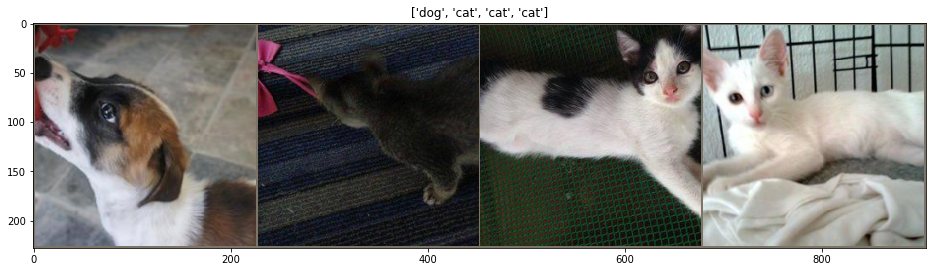

In [10]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])

# original tutorial

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25,dataloaders=dataloaders):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            print(inputs.shape, outputs.shape)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                cv2.imwrite('out.png',inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


In [13]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)
#model_ft = model_newinput.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [14]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=1)#25)

Epoch 0/0
----------
train Loss: 0.1307 Acc: 0.9480
valid Loss: 0.0419 Acc: 0.9861

Training complete in 26m 26s
Best val Acc: 0.986145


In [35]:
torch.save(model_ft, 'resnet18_catdog_1ep.pth')

In [6]:
model_ft = torch.load('resnet18_catdog_1ep.pth')

In [14]:
def preprocess_image(img):
	img = np.float32(cv2.resize(img, (224, 224))) / 255
	means=[0.485, 0.456, 0.406]
	stds=[0.229, 0.224, 0.225]

	preprocessed_img = img.copy()[: , :, ::-1]
	for i in range(3):
		preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - means[i]
		preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / stds[i]
	preprocessed_img = \
		np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))
	preprocessed_img = torch.from_numpy(preprocessed_img)
	preprocessed_img.unsqueeze_(0)
	input = Variable(preprocessed_img, requires_grad = True)
	return input.cuda()
# 000a290e4-1 dog
# 00a1f270a-1 cat
img = cv2.imread('input/petfinder-adoption-prediction/train_images/00a1f270a-1.jpg', 1)
#print(img)
#img = np.float32(cv2.resize(img, (224, 224))) / 255
inp = preprocess_image(img)
#tryim = load_image('input/petfinder-adoption-prediction/train_images/','86e1089a3')
net = model_ft#torch.load('resnet50_trained3.pth')
#print(net)

net.eval()
output = net(inp)
print(output) #print output from crossentropy score

sm = torch.nn.Softmax()
probabilities = sm(output) 
print(probabilities) #Converted to probabilities #tensor[catness, dogness]

tensor([[ 2.0617, -1.4259]], device='cuda:0', grad_fn=<AddmmBackward>)


C:\Users\vinograd\Anaconda3_12\envs\pytorch_gpu\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[0.9703, 0.0297]], device='cuda:0', grad_fn=<SoftmaxBackward>)


In [9]:
# 000a290e4-1 dog
# 00a1f270a-1 cat
img = cv2.imread('input/petfinder-adoption-prediction/train_images/000a290e4-1.jpg', 1)
#print(img)
img = np.float32(cv2.resize(img, (224, 224))) / 255
inp = preprocess_image(img)
#tryim = load_image('input/petfinder-adoption-prediction/train_images/','86e1089a3')
net = model_ft#torch.load('resnet50_trained3.pth')
#print(net)

net.eval()
output = net(inp)
print(output) #print output from crossentropy score

sm = torch.nn.Softmax()
probabilities = sm(output) 
print(probabilities) #Converted to probabilities

tensor([[-3.6284,  4.7217]], device='cuda:0', grad_fn=<AddmmBackward>)


C:\Users\vinograd\Anaconda3_12\envs\pytorch_gpu\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


tensor([[2.3630e-04, 9.9976e-01]], device='cuda:0', grad_fn=<SoftmaxBackward>)


In [11]:
probabilities.cpu().detach().numpy()

array([[2.3629954e-04, 9.9976367e-01]], dtype=float32)

In [12]:
train_petids = train_df['PetID'].values
train_petids

array(['86e1089a3', '6296e909a', '3422e4906', ..., 'd981b6395',
       'e4da1c9e4', 'a83d95ead'], dtype=object)

In [17]:
for train_petid in tqdm(train_petids[:5]): 
    row = data_df.loc[data_df['PetID'] == train_petid, :] 
    photo_amt = row['PhotoAmt'].values[0] 
    typ = row['Type'].values[0] 
    adoption = row['AdoptionSpeed'].values[0] 
    if photo_amt>0 :#and adoption>=0: 
        #if typ==1: mark = 'dog' if typ==2: mark = 'cat' 
        i=1 
        img_name = str(train_petid)+'-'+str(i)+'.jpg'
        img = cv2.imread(root_dir+img_name, 1)
#print(img)
#img = np.float32(cv2.resize(img, (224, 224))) / 255
        inp = preprocess_image(img)
#tryim = load_image('input/petfinder-adoption-prediction/train_images/','86e1089a3')
#net = model_ft#torch.load('resnet50_trained3.pth')
#print(net)

#net.eval()
        output = net(inp)
        print(output) #print output from crossentropy score

        sm = torch.nn.Softmax()
        probabilities = sm(output) 
        probabilities = probabilities.cpu().detach().numpy()
        print(probabilities)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

tensor([[ 5.0952, -4.2838]], device='cuda:0', grad_fn=<AddmmBackward>)


C:\Users\vinograd\Anaconda3_12\envs\pytorch_gpu\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[9.9991548e-01 8.4479616e-05]]


 20%|████████████████▊                                                                   | 1/5 [00:00<00:01,  2.89it/s]

tensor([[ 3.4180, -2.5629]], device='cuda:0', grad_fn=<AddmmBackward>)
[[0.9974796  0.00252035]]
tensor([[-4.1203,  5.3020]], device='cuda:0', grad_fn=<AddmmBackward>)
[[8.0895625e-05 9.9991906e-01]]


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:00<00:00,  3.78it/s]

tensor([[-4.7693,  6.3188]], device='cuda:0', grad_fn=<AddmmBackward>)
[[1.5292559e-05 9.9998474e-01]]
tensor([[-4.4899,  6.3032]], device='cuda:0', grad_fn=<AddmmBackward>)
[[2.0540278e-05 9.9997950e-01]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


In [28]:
new_model_2_removed = nn.Sequential(*list(model_ft.children())[1:])
child_counter = 0
for child in new_model_2_removed.children():
    print(" child", child_counter, "is -")
    print(child)
    child_counter += 1

 child 0 is -
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 child 1 is -
ReLU(inplace)
 child 2 is -
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
 child 3 is -
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1

## Finetuning the pretrained model

In [44]:
image_features = []
def hook_feature(module, input, output):
    # hook the feature extractor
    image_features.append(np.squeeze(output.data.cpu().numpy()))

model._modules.get('avgpool').register_forward_hook(hook_feature)

## Extract Train Image Features

In [45]:
model = model_ft
extract_transform = image_transforms['valid']

In [50]:
train_pids = train_df.PetID.values
input_tensor = torch.zeros(1, 3, 224, 224)

train_image_features = {}
for petid in tqdm(train_pids):
    #print(petid)
    train_img = r'./input/petfinder-adoption-prediction/train_images/'+petid+'-1.jpg'
    if not os.path.exists(train_img): 
        print('no image!')
        continue
    
    train_img = Image.open(train_img)
    train_img = extract_transform(train_img)
    input_tensor[0, :, :, :] = train_img
    input_tensor = input_tensor.cuda()
    model(input_tensor)
    train_image_features[petid] = image_features[0]
    image_features.clear()


  0%|                                                                               | 18/14993 [00:00<02:51, 87.42it/s]

no image!
no image!
no image!


  0%|▎                                                                              | 48/14993 [00:00<02:44, 90.82it/s]

no image!


  1%|▍                                                                              | 85/14993 [00:00<02:49, 87.93it/s]

no image!


  1%|▌                                                                             | 113/14993 [00:01<02:53, 85.83it/s]

no image!


  1%|▊                                                                             | 159/14993 [00:01<02:53, 85.30it/s]

no image!


  1%|▉                                                                             | 178/14993 [00:02<02:50, 86.73it/s]

no image!


  1%|█▏                                                                            | 224/14993 [00:02<02:53, 85.32it/s]

no image!


  2%|█▏                                                                            | 233/14993 [00:02<02:53, 85.26it/s]

no image!


  2%|█▎                                                                            | 261/14993 [00:02<02:52, 85.37it/s]

no image!


  2%|█▌                                                                            | 298/14993 [00:03<02:50, 86.03it/s]

no image!


  2%|█▊                                                                            | 353/14993 [00:04<02:58, 81.93it/s]

no image!


  2%|█▉                                                                            | 362/14993 [00:04<02:58, 81.97it/s]

no image!


  3%|█▉                                                                            | 381/14993 [00:04<02:53, 84.12it/s]

no image!


  3%|██▍                                                                           | 462/14993 [00:05<03:00, 80.71it/s]

no image!


  3%|██▋                                                                           | 508/14993 [00:05<02:57, 81.46it/s]

no image!
no image!


  3%|██▋                                                                           | 518/14993 [00:06<02:48, 86.09it/s]

no image!


  4%|██▊                                                                           | 536/14993 [00:06<02:49, 85.23it/s]

no image!


  4%|███                                                                           | 591/14993 [00:06<02:56, 81.55it/s]

no image!
no image!


  4%|███▏                                                                          | 611/14993 [00:07<02:47, 85.94it/s]

no image!


  5%|███▉                                                                          | 756/14993 [00:08<02:55, 81.11it/s]

no image!


  5%|████                                                                          | 774/14993 [00:09<02:53, 81.90it/s]

no image!


  5%|████                                                                          | 784/14993 [00:09<02:46, 85.33it/s]

no image!


  6%|████▎                                                                         | 830/14993 [00:09<02:46, 85.08it/s]

no image!


  6%|████▍                                                                         | 849/14993 [00:09<02:43, 86.31it/s]

no image!


  6%|████▋                                                                         | 895/14993 [00:10<02:52, 81.74it/s]

no image!


  7%|█████▏                                                                        | 986/14993 [00:11<02:49, 82.43it/s]

no image!


  7%|█████▏                                                                       | 1005/14993 [00:11<02:44, 84.92it/s]

no image!
no image!


  7%|█████▎                                                                       | 1043/14993 [00:12<02:49, 82.25it/s]

no image!


  7%|█████▋                                                                       | 1098/14993 [00:12<02:45, 84.09it/s]

no image!


  8%|█████▉                                                                       | 1152/14993 [00:13<02:43, 84.57it/s]

no image!


  8%|██████                                                                       | 1171/14993 [00:13<02:39, 86.42it/s]

no image!


  8%|██████▏                                                                      | 1199/14993 [00:14<02:42, 84.78it/s]

no image!


  8%|██████▎                                                                      | 1236/14993 [00:14<02:43, 84.29it/s]

no image!


  8%|██████▌                                                                      | 1273/14993 [00:14<02:44, 83.42it/s]

no image!
no image!


  9%|██████▌                                                                      | 1284/14993 [00:15<02:36, 87.64it/s]

no image!
no image!


  9%|███████▎                                                                     | 1413/14993 [00:16<02:40, 84.45it/s]

no image!


 10%|███████▉                                                                     | 1548/14993 [00:18<02:43, 82.40it/s]

no image!


 11%|████████▍                                                                    | 1639/14993 [00:19<02:45, 80.79it/s]

no image!


 11%|████████▌                                                                    | 1657/14993 [00:19<02:43, 81.73it/s]

no image!


 11%|████████▌                                                                    | 1667/14993 [00:19<02:37, 84.35it/s]

no image!


 11%|████████▋                                                                    | 1686/14993 [00:19<02:35, 85.51it/s]

no image!


 11%|████████▊                                                                    | 1704/14993 [00:20<02:38, 83.84it/s]

no image!


 12%|████████▉                                                                    | 1732/14993 [00:20<02:36, 84.71it/s]

no image!


 12%|█████████▎                                                                   | 1823/14993 [00:21<02:34, 84.98it/s]

no image!


 12%|█████████▍                                                                   | 1833/14993 [00:21<02:32, 86.29it/s]

no image!


 12%|█████████▌                                                                   | 1861/14993 [00:21<02:38, 82.71it/s]

no image!
no image!


 14%|██████████▊                                                                  | 2106/14993 [00:24<02:34, 83.28it/s]

no image!


 15%|███████████▍                                                                 | 2224/14993 [00:26<02:34, 82.88it/s]

no image!
no image!


 15%|███████████▍                                                                 | 2235/14993 [00:26<02:26, 87.22it/s]

no image!


 15%|███████████▌                                                                 | 2245/14993 [00:26<02:21, 89.79it/s]

no image!


 15%|███████████▋                                                                 | 2283/14993 [00:27<02:30, 84.30it/s]

no image!


 15%|███████████▊                                                                 | 2293/14993 [00:27<02:26, 86.69it/s]

no image!


 16%|████████████▎                                                                | 2393/14993 [00:28<02:29, 84.38it/s]

no image!


 16%|████████████▎                                                                | 2403/14993 [00:28<02:25, 86.75it/s]

no image!


 16%|████████████▌                                                                | 2458/14993 [00:29<02:26, 85.49it/s]

no image!
no image!


 17%|████████████▊                                                                | 2489/14993 [00:29<02:24, 86.49it/s]

no image!


 17%|████████████▊                                                                | 2499/14993 [00:29<02:19, 89.49it/s]

no image!


 17%|█████████████                                                                | 2538/14993 [00:29<02:23, 86.71it/s]

no image!


 17%|█████████████▏                                                               | 2566/14993 [00:30<02:21, 87.74it/s]

no image!


 17%|█████████████▎                                                               | 2603/14993 [00:30<02:21, 87.63it/s]

no image!


 17%|█████████████▍                                                               | 2613/14993 [00:30<02:17, 90.09it/s]

no image!


 18%|█████████████▉                                                               | 2708/14993 [00:31<02:23, 85.51it/s]

no image!


 18%|██████████████                                                               | 2727/14993 [00:32<02:19, 87.79it/s]

no image!


 18%|██████████████                                                               | 2737/14993 [00:32<02:15, 90.46it/s]

no image!


 19%|██████████████▍                                                              | 2812/14993 [00:33<02:24, 84.44it/s]

no image!


 19%|██████████████▉                                                              | 2903/14993 [00:34<02:21, 85.62it/s]

no image!


 20%|███████████████                                                              | 2932/14993 [00:34<02:19, 86.55it/s]

no image!


 20%|███████████████▏                                                             | 2960/14993 [00:34<02:15, 88.76it/s]

no image!


 20%|███████████████▎                                                             | 2980/14993 [00:34<02:15, 88.96it/s]

no image!


 20%|███████████████▍                                                             | 3000/14993 [00:35<02:12, 90.43it/s]

no image!


 20%|███████████████▌                                                             | 3030/14993 [00:35<02:14, 89.26it/s]

no image!


 20%|███████████████▋                                                             | 3050/14993 [00:35<02:13, 89.54it/s]

no image!


 20%|███████████████▊                                                             | 3070/14993 [00:35<02:11, 90.68it/s]

no image!


 21%|████████████████▎                                                            | 3182/14993 [00:37<02:19, 84.71it/s]

no image!


 22%|████████████████▉                                                            | 3291/14993 [00:38<02:22, 82.15it/s]

no image!


 22%|████████████████▉                                                            | 3310/14993 [00:38<02:14, 86.64it/s]

no image!
no image!


 22%|█████████████████▏                                                           | 3351/14993 [00:39<02:10, 89.40it/s]

no image!


 23%|█████████████████▌                                                           | 3418/14993 [00:39<02:12, 87.52it/s]

no image!


 23%|█████████████████▌                                                           | 3429/14993 [00:40<02:07, 90.99it/s]

no image!
no image!
no image!


 23%|█████████████████▊                                                           | 3461/14993 [00:40<02:09, 88.80it/s]

no image!


 23%|█████████████████▊                                                           | 3471/14993 [00:40<02:09, 89.25it/s]

no image!


 23%|█████████████████▉                                                           | 3502/14993 [00:40<02:10, 88.10it/s]

no image!


 24%|██████████████████▌                                                          | 3621/14993 [00:42<02:11, 86.57it/s]

no image!


 25%|███████████████████                                                          | 3704/14993 [00:43<02:11, 85.63it/s]

no image!


 25%|███████████████████                                                          | 3723/14993 [00:43<02:06, 88.79it/s]

no image!


 25%|███████████████████▏                                                         | 3733/14993 [00:43<02:03, 91.20it/s]

no image!


 25%|███████████████████▏                                                         | 3743/14993 [00:43<02:00, 93.22it/s]

no image!


 25%|███████████████████▍                                                         | 3783/14993 [00:44<02:07, 87.76it/s]

no image!


 26%|████████████████████                                                         | 3905/14993 [00:45<02:07, 86.86it/s]

no image!


 26%|████████████████████▏                                                        | 3942/14993 [00:45<02:10, 84.77it/s]

no image!
no image!


 26%|████████████████████▍                                                        | 3972/14993 [00:46<02:04, 88.69it/s]

no image!


 27%|████████████████████▋                                                        | 4018/14993 [00:46<02:08, 85.53it/s]

no image!


 27%|████████████████████▉                                                        | 4065/14993 [00:47<02:05, 87.15it/s]

no image!


 27%|████████████████████▉                                                        | 4083/14993 [00:47<02:11, 82.68it/s]

no image!


 27%|█████████████████████                                                        | 4101/14993 [00:47<02:07, 85.46it/s]

no image!


 29%|██████████████████████                                                       | 4292/14993 [00:50<02:07, 84.02it/s]

no image!


 30%|██████████████████████▉                                                      | 4456/14993 [00:51<02:02, 86.01it/s]

no image!


 30%|███████████████████████▏                                                     | 4503/14993 [00:52<02:00, 86.73it/s]

no image!
no image!


 33%|█████████████████████████▏                                                   | 4902/14993 [00:57<01:58, 85.29it/s]

no image!


 33%|█████████████████████████▎                                                   | 4930/14993 [00:57<01:55, 86.84it/s]

no image!


 33%|█████████████████████████▎                                                   | 4940/14993 [00:57<01:53, 88.32it/s]

no image!


 33%|█████████████████████████▍                                                   | 4950/14993 [00:57<01:50, 90.60it/s]

no image!


 33%|█████████████████████████▌                                                   | 4989/14993 [00:58<02:01, 82.06it/s]

no image!


 34%|██████████████████████████                                                   | 5081/14993 [00:59<01:53, 87.23it/s]

no image!
no image!


 34%|██████████████████████████▎                                                  | 5130/14993 [00:59<01:54, 86.20it/s]

no image!


 34%|██████████████████████████▌                                                  | 5167/14993 [01:00<01:55, 84.89it/s]

no image!


 35%|██████████████████████████▌                                                  | 5177/14993 [01:00<01:51, 87.81it/s]

no image!
no image!


 36%|███████████████████████████▍                                                 | 5332/14993 [01:01<01:58, 81.58it/s]

no image!
no image!


 36%|███████████████████████████▌                                                 | 5362/14993 [01:02<01:51, 86.72it/s]

no image!


 36%|███████████████████████████▋                                                 | 5400/14993 [01:02<01:46, 89.80it/s]

no image!
no image!
no image!
no image!


 36%|███████████████████████████▊                                                 | 5424/14993 [01:02<01:41, 93.98it/s]

no image!


 37%|████████████████████████████                                                 | 5473/14993 [01:03<01:50, 86.18it/s]

no image!


 37%|████████████████████████████▎                                                | 5510/14993 [01:03<01:48, 87.05it/s]

no image!


 37%|████████████████████████████▍                                                | 5529/14993 [01:04<01:46, 88.71it/s]

no image!


 37%|████████████████████████████▌                                                | 5558/14993 [01:04<01:48, 86.98it/s]

no image!


 37%|████████████████████████████▋                                                | 5578/14993 [01:04<01:44, 90.33it/s]

no image!


 38%|█████████████████████████████▎                                               | 5709/14993 [01:06<01:53, 81.64it/s]

no image!


 38%|█████████████████████████████▍                                               | 5737/14993 [01:06<01:47, 86.14it/s]

no image!


 38%|█████████████████████████████▌                                               | 5747/14993 [01:06<01:45, 87.81it/s]

no image!


 39%|█████████████████████████████▋                                               | 5784/14993 [01:07<01:47, 85.31it/s]

no image!


 39%|█████████████████████████████▊                                               | 5794/14993 [01:07<01:44, 87.90it/s]

no image!


 40%|██████████████████████████████▍                                              | 5934/14993 [01:08<01:50, 81.83it/s]

no image!


 40%|██████████████████████████████▌                                              | 5944/14993 [01:08<01:45, 85.50it/s]

no image!
no image!


 40%|██████████████████████████████▌                                              | 5955/14993 [01:09<01:41, 89.45it/s]

no image!


 40%|██████████████████████████████▋                                              | 5965/14993 [01:09<01:37, 92.19it/s]

no image!


 40%|██████████████████████████████▊                                              | 6004/14993 [01:09<01:45, 85.16it/s]

no image!


 40%|███████████████████████████████▏                                             | 6068/14993 [01:10<01:45, 84.32it/s]

no image!


 41%|███████████████████████████████▌                                             | 6150/14993 [01:11<01:47, 82.53it/s]

no image!


 41%|███████████████████████████████▋                                             | 6169/14993 [01:11<01:44, 84.41it/s]

no image!


 42%|████████████████████████████████▎                                            | 6288/14993 [01:12<01:41, 85.62it/s]

no image!
no image!


 43%|████████████████████████████████▊                                            | 6397/14993 [01:14<01:42, 83.54it/s]

no image!


 43%|█████████████████████████████████▎                                           | 6479/14993 [01:15<01:40, 84.59it/s]

no image!


 43%|█████████████████████████████████▍                                           | 6499/14993 [01:15<01:35, 88.93it/s]

no image!


 43%|█████████████████████████████████▍                                           | 6509/14993 [01:15<01:33, 90.80it/s]

no image!


 44%|█████████████████████████████████▌                                           | 6529/14993 [01:15<01:34, 89.95it/s]

no image!


 44%|█████████████████████████████████▋                                           | 6558/14993 [01:16<01:40, 84.11it/s]

no image!


 44%|█████████████████████████████████▋                                           | 6567/14993 [01:16<01:41, 83.01it/s]

no image!


 44%|█████████████████████████████████▉                                           | 6613/14993 [01:16<01:38, 84.76it/s]

no image!


 45%|██████████████████████████████████▎                                          | 6685/14993 [01:17<01:39, 83.88it/s]

no image!


 45%|██████████████████████████████████▍                                          | 6714/14993 [01:17<01:34, 87.99it/s]

no image!


 45%|██████████████████████████████████▋                                          | 6761/14993 [01:18<01:35, 86.33it/s]

no image!
no image!


 45%|██████████████████████████████████▊                                          | 6772/14993 [01:18<01:31, 90.09it/s]

no image!


 46%|███████████████████████████████████▍                                         | 6911/14993 [01:20<01:34, 85.15it/s]

no image!


 47%|████████████████████████████████████                                         | 7021/14993 [01:21<01:32, 86.62it/s]

no image!


 47%|████████████████████████████████████▎                                        | 7068/14993 [01:21<01:32, 85.81it/s]

no image!
no image!
no image!


 47%|████████████████████████████████████▍                                        | 7090/14993 [01:22<01:30, 87.73it/s]

no image!


 48%|████████████████████████████████████▋                                        | 7146/14993 [01:22<01:33, 84.19it/s]

no image!


 48%|████████████████████████████████████▉                                        | 7201/14993 [01:23<01:30, 85.98it/s]

no image!


 48%|█████████████████████████████████████                                        | 7211/14993 [01:23<01:28, 88.16it/s]

no image!


 48%|█████████████████████████████████████                                        | 7222/14993 [01:23<01:24, 91.47it/s]

no image!


 49%|█████████████████████████████████████▌                                       | 7323/14993 [01:24<01:29, 85.92it/s]

no image!


 49%|█████████████████████████████████████▊                                       | 7351/14993 [01:25<01:28, 86.55it/s]

no image!


 49%|██████████████████████████████████████                                       | 7407/14993 [01:25<01:27, 86.30it/s]

no image!
no image!


 50%|██████████████████████████████████████▏                                      | 7436/14993 [01:26<01:26, 87.72it/s]

no image!


 50%|██████████████████████████████████████▏                                      | 7446/14993 [01:26<01:23, 90.89it/s]

no image!


 50%|██████████████████████████████████████▊                                      | 7549/14993 [01:27<01:27, 84.72it/s]

no image!


 50%|██████████████████████████████████████▊                                      | 7559/14993 [01:27<01:25, 87.23it/s]

no image!


 51%|███████████████████████████████████████▏                                     | 7632/14993 [01:28<01:25, 86.20it/s]

no image!


 51%|███████████████████████████████████████▎                                     | 7651/14993 [01:28<01:22, 88.76it/s]

no image!


 51%|███████████████████████████████████████▌                                     | 7699/14993 [01:29<01:23, 87.66it/s]

no image!


 52%|███████████████████████████████████████▋                                     | 7728/14993 [01:29<01:25, 84.70it/s]

no image!


 52%|███████████████████████████████████████▉                                     | 7782/14993 [01:30<01:26, 83.12it/s]

no image!


 52%|████████████████████████████████████████                                     | 7802/14993 [01:30<01:21, 88.48it/s]

no image!


 52%|████████████████████████████████████████▏                                    | 7821/14993 [01:30<01:21, 87.82it/s]

no image!


 53%|████████████████████████████████████████▊                                    | 7950/14993 [01:32<01:24, 83.43it/s]

no image!


 53%|█████████████████████████████████████████▏                                   | 8014/14993 [01:32<01:20, 86.34it/s]

no image!


 54%|█████████████████████████████████████████▍                                   | 8059/14993 [01:33<01:20, 85.88it/s]

no image!


 54%|█████████████████████████████████████████▋                                   | 8107/14993 [01:33<01:17, 88.50it/s]

no image!


 54%|█████████████████████████████████████████▋                                   | 8117/14993 [01:34<01:15, 90.73it/s]

no image!


 55%|█████████████████████████████████████████▉                                   | 8175/14993 [01:34<01:17, 88.23it/s]

no image!


 55%|██████████████████████████████████████████▏                                  | 8203/14993 [01:35<01:18, 86.20it/s]

no image!


 55%|██████████████████████████████████████████▏                                  | 8212/14993 [01:35<01:19, 85.15it/s]

no image!


 55%|██████████████████████████████████████████▋                                  | 8321/14993 [01:36<01:18, 85.19it/s]

no image!


 56%|██████████████████████████████████████████▊                                  | 8340/14993 [01:36<01:16, 86.42it/s]

no image!


 56%|███████████████████████████████████████████                                  | 8377/14993 [01:37<01:18, 84.33it/s]

no image!
no image!


 56%|███████████████████████████████████████████                                  | 8397/14993 [01:37<01:16, 86.35it/s]

no image!


 56%|███████████████████████████████████████████▎                                 | 8427/14993 [01:37<01:15, 86.45it/s]

no image!


 57%|███████████████████████████████████████████▋                                 | 8517/14993 [01:38<01:16, 85.05it/s]

no image!


 57%|███████████████████████████████████████████▉                                 | 8554/14993 [01:39<01:14, 86.86it/s]

no image!


 57%|████████████████████████████████████████████                                 | 8591/14993 [01:39<01:13, 86.79it/s]

no image!


 58%|████████████████████████████████████████████▎                                | 8637/14993 [01:40<01:14, 85.55it/s]

no image!


 58%|████████████████████████████████████████████▌                                | 8665/14993 [01:40<01:12, 87.13it/s]

no image!


 58%|████████████████████████████████████████████▋                                | 8694/14993 [01:40<01:11, 87.75it/s]

no image!


 58%|████████████████████████████████████████████▋                                | 8704/14993 [01:40<01:09, 89.93it/s]

no image!


 58%|████████████████████████████████████████████▊                                | 8714/14993 [01:40<01:08, 91.79it/s]

no image!
no image!


 58%|████████████████████████████████████████████▊                                | 8735/14993 [01:41<01:07, 92.03it/s]

no image!


 58%|████████████████████████████████████████████▉                                | 8755/14993 [01:41<01:08, 91.70it/s]

no image!


 59%|█████████████████████████████████████████████▏                               | 8795/14993 [01:41<01:09, 89.30it/s]

no image!


 59%|█████████████████████████████████████████████▎                               | 8833/14993 [01:42<01:10, 87.41it/s]

no image!


 59%|█████████████████████████████████████████████▋                               | 8899/14993 [01:42<01:10, 86.75it/s]

no image!
no image!


 60%|█████████████████████████████████████████████▉                               | 8948/14993 [01:43<01:08, 87.76it/s]

no image!


 60%|██████████████████████████████████████████████                               | 8969/14993 [01:43<01:06, 89.94it/s]

no image!


 60%|██████████████████████████████████████████████▎                              | 9008/14993 [01:44<01:06, 89.47it/s]

no image!


 60%|██████████████████████████████████████████████▎                              | 9017/14993 [01:44<01:07, 89.16it/s]

no image!


 61%|██████████████████████████████████████████████▌                              | 9073/14993 [01:44<01:07, 87.48it/s]

no image!
no image!


 61%|███████████████████████████████████████████████                              | 9169/14993 [01:45<01:07, 86.31it/s]

no image!


 62%|████████████████████████████████████████████████                             | 9353/14993 [01:48<01:06, 84.44it/s]

no image!


 63%|████████████████████████████████████████████████▏                            | 9372/14993 [01:48<01:04, 87.77it/s]

no image!


 63%|████████████████████████████████████████████████▎                            | 9418/14993 [01:48<01:04, 86.12it/s]

no image!


 63%|████████████████████████████████████████████████▍                            | 9437/14993 [01:49<01:04, 85.84it/s]

no image!


 63%|████████████████████████████████████████████████▌                            | 9447/14993 [01:49<01:03, 86.91it/s]

no image!


 63%|████████████████████████████████████████████████▌                            | 9457/14993 [01:49<01:01, 89.56it/s]

no image!


 64%|████████████████████████████████████████████████▉                            | 9533/14993 [01:50<01:03, 85.85it/s]

no image!


 64%|█████████████████████████████████████████████████▌                           | 9642/14993 [01:51<01:02, 85.12it/s]

no image!


 64%|█████████████████████████████████████████████████▌                           | 9652/14993 [01:51<01:01, 87.07it/s]

no image!


 66%|██████████████████████████████████████████████████▍                          | 9826/14993 [01:53<00:59, 87.10it/s]

no image!


 66%|██████████████████████████████████████████████████▋                          | 9863/14993 [01:53<00:59, 86.44it/s]

no image!


 66%|██████████████████████████████████████████████████▊                          | 9890/14993 [01:54<00:57, 88.33it/s]

no image!


 67%|██████████████████████████████████████████████████▉                         | 10044/14993 [01:56<00:59, 83.86it/s]

no image!
no image!


 68%|███████████████████████████████████████████████████▎                        | 10127/14993 [01:57<00:58, 83.88it/s]

no image!


 68%|███████████████████████████████████████████████████▍                        | 10147/14993 [01:57<00:54, 88.18it/s]

no image!


 69%|████████████████████████████████████████████████████                        | 10272/14993 [01:58<00:54, 86.60it/s]

no image!


 69%|████████████████████████████████████████████████████▏                       | 10300/14993 [01:59<00:53, 88.22it/s]

no image!
no image!


 69%|████████████████████████████████████████████████████▎                       | 10331/14993 [01:59<00:51, 91.38it/s]

no image!


 70%|████████████████████████████████████████████████████▊                       | 10424/14993 [02:00<00:53, 85.98it/s]

no image!


 70%|████████████████████████████████████████████████████▉                       | 10434/14993 [02:00<00:51, 88.87it/s]

no image!


 70%|█████████████████████████████████████████████████████                       | 10464/14993 [02:00<00:50, 89.21it/s]

no image!


 70%|█████████████████████████████████████████████████████▏                      | 10484/14993 [02:01<00:50, 88.80it/s]

no image!


 71%|██████████████████████████████████████████████████████▏                     | 10679/14993 [02:03<00:50, 85.33it/s]

no image!


 72%|██████████████████████████████████████████████████████▌                     | 10752/14993 [02:04<00:48, 86.63it/s]

no image!


 72%|██████████████████████████████████████████████████████▊                     | 10818/14993 [02:04<00:47, 88.20it/s]

no image!


 73%|███████████████████████████████████████████████████████▎                    | 10909/14993 [02:05<00:48, 84.35it/s]

no image!


 73%|███████████████████████████████████████████████████████▍                    | 10947/14993 [02:06<00:45, 88.50it/s]

no image!


 73%|███████████████████████████████████████████████████████▋                    | 10985/14993 [02:06<00:47, 85.26it/s]

no image!


 73%|███████████████████████████████████████████████████████▊                    | 11012/14993 [02:07<00:45, 86.59it/s]

no image!


 74%|████████████████████████████████████████████████████████▌                   | 11148/14993 [02:08<00:44, 86.89it/s]

no image!


 75%|████████████████████████████████████████████████████████▊                   | 11205/14993 [02:09<00:44, 86.00it/s]

no image!


 75%|████████████████████████████████████████████████████████▉                   | 11233/14993 [02:09<00:44, 85.25it/s]

no image!
no image!


 75%|█████████████████████████████████████████████████████████                   | 11254/14993 [02:09<00:42, 87.39it/s]

no image!


 75%|█████████████████████████████████████████████████████████                   | 11263/14993 [02:10<00:42, 87.20it/s]

no image!


 76%|█████████████████████████████████████████████████████████▍                  | 11328/14993 [02:10<00:43, 84.73it/s]

no image!


 76%|█████████████████████████████████████████████████████████▉                  | 11437/14993 [02:12<00:42, 83.88it/s]

no image!


 77%|██████████████████████████████████████████████████████████▋                 | 11574/14993 [02:13<00:41, 82.43it/s]

no image!


 77%|██████████████████████████████████████████████████████████▋                 | 11584/14993 [02:13<00:40, 85.08it/s]

no image!


 77%|██████████████████████████████████████████████████████████▊                 | 11612/14993 [02:14<00:40, 82.59it/s]

no image!


 78%|██████████████████████████████████████████████████████████▉                 | 11622/14993 [02:14<00:39, 84.98it/s]

no image!


 78%|███████████████████████████████████████████████████████████▍                | 11723/14993 [02:15<00:39, 82.79it/s]

no image!
no image!


 79%|███████████████████████████████████████████████████████████▊                | 11792/14993 [02:16<00:42, 75.96it/s]

no image!


 79%|███████████████████████████████████████████████████████████▊                | 11801/14993 [02:16<00:40, 78.91it/s]

no image!


 79%|████████████████████████████████████████████████████████████                | 11861/14993 [02:17<00:39, 78.71it/s]

no image!


 79%|████████████████████████████████████████████████████████████▍               | 11916/14993 [02:17<00:36, 85.26it/s]

no image!


 80%|████████████████████████████████████████████████████████████▌               | 11943/14993 [02:18<00:35, 86.44it/s]

no image!


 81%|█████████████████████████████████████████████████████████████▋              | 12159/14993 [02:20<00:34, 81.56it/s]

no image!


 81%|█████████████████████████████████████████████████████████████▋              | 12169/14993 [02:20<00:33, 85.29it/s]

no image!


 81%|█████████████████████████████████████████████████████████████▋              | 12178/14993 [02:21<00:32, 86.22it/s]

no image!
no image!


 81%|█████████████████████████████████████████████████████████████▉              | 12208/14993 [02:21<00:31, 88.15it/s]

no image!


 82%|█████████████████████████████████████████████████████████████▉              | 12227/14993 [02:21<00:31, 86.72it/s]

no image!
no image!


 82%|██████████████████████████████████████████████████████████████▏             | 12256/14993 [02:21<00:30, 89.12it/s]

no image!


 83%|██████████████████████████████████████████████████████████████▋             | 12378/14993 [02:23<00:30, 84.45it/s]

no image!


 83%|██████████████████████████████████████████████████████████████▊             | 12397/14993 [02:23<00:30, 85.35it/s]

no image!


 83%|███████████████████████████████████████████████████████████████▎            | 12480/14993 [02:24<00:29, 84.40it/s]

no image!


 84%|███████████████████████████████████████████████████████████████▍            | 12526/14993 [02:24<00:29, 84.20it/s]

no image!


 84%|████████████████████████████████████████████████████████████████▏           | 12662/14993 [02:26<00:27, 85.85it/s]

no image!


 85%|████████████████████████████████████████████████████████████████▍           | 12717/14993 [02:27<00:26, 86.62it/s]

no image!


 85%|████████████████████████████████████████████████████████████████▌           | 12746/14993 [02:27<00:25, 87.71it/s]

no image!


 86%|█████████████████████████████████████████████████████████████████▏          | 12866/14993 [02:28<00:24, 85.62it/s]

no image!


 86%|█████████████████████████████████████████████████████████████████▌          | 12922/14993 [02:29<00:23, 87.80it/s]

no image!


 87%|██████████████████████████████████████████████████████████████████▏         | 13051/14993 [02:31<00:22, 84.86it/s]

no image!


 88%|██████████████████████████████████████████████████████████████████▊         | 13189/14993 [02:32<00:20, 85.94it/s]

no image!


 88%|██████████████████████████████████████████████████████████████████▉         | 13208/14993 [02:32<00:20, 86.06it/s]

no image!


 88%|███████████████████████████████████████████████████████████████████         | 13218/14993 [02:32<00:19, 88.92it/s]

no image!


 89%|███████████████████████████████████████████████████████████████████▌        | 13320/14993 [02:34<00:19, 86.31it/s]

no image!


 89%|███████████████████████████████████████████████████████████████████▌        | 13330/14993 [02:34<00:18, 88.40it/s]

no image!
no image!


 89%|███████████████████████████████████████████████████████████████████▊        | 13380/14993 [02:34<00:18, 86.96it/s]

no image!
no image!


 90%|████████████████████████████████████████████████████████████████████▏       | 13454/14993 [02:35<00:18, 84.79it/s]

no image!


 90%|████████████████████████████████████████████████████████████████████▍       | 13501/14993 [02:36<00:17, 85.83it/s]

no image!


 90%|████████████████████████████████████████████████████████████████████▊       | 13567/14993 [02:36<00:16, 85.28it/s]

no image!


 91%|████████████████████████████████████████████████████████████████████▉       | 13604/14993 [02:37<00:15, 87.67it/s]

no image!


 91%|█████████████████████████████████████████████████████████████████████▏      | 13652/14993 [02:37<00:15, 88.12it/s]

no image!


 91%|█████████████████████████████████████████████████████████████████████▍      | 13699/14993 [02:38<00:14, 87.52it/s]

no image!


 92%|█████████████████████████████████████████████████████████████████████▊      | 13763/14993 [02:39<00:14, 85.79it/s]

no image!
no image!


 92%|██████████████████████████████████████████████████████████████████████      | 13822/14993 [02:39<00:13, 88.36it/s]

no image!


 92%|██████████████████████████████████████████████████████████████████████▎     | 13861/14993 [02:40<00:13, 86.08it/s]

no image!


 93%|██████████████████████████████████████████████████████████████████████▎     | 13880/14993 [02:40<00:12, 86.87it/s]

no image!


 93%|██████████████████████████████████████████████████████████████████████▌     | 13919/14993 [02:40<00:12, 89.32it/s]

no image!


 93%|██████████████████████████████████████████████████████████████████████▌     | 13928/14993 [02:40<00:11, 89.33it/s]

no image!


 94%|███████████████████████████████████████████████████████████████████████▏    | 14050/14993 [02:42<00:10, 86.66it/s]

no image!


 94%|███████████████████████████████████████████████████████████████████████▌    | 14118/14993 [02:43<00:10, 86.24it/s]

no image!


 94%|███████████████████████████████████████████████████████████████████████▋    | 14147/14993 [02:43<00:09, 88.49it/s]

no image!


 95%|███████████████████████████████████████████████████████████████████████▉    | 14203/14993 [02:44<00:09, 85.79it/s]

no image!


 95%|████████████████████████████████████████████████████████████████████████    | 14223/14993 [02:44<00:08, 86.70it/s]

no image!


 95%|████████████████████████████████████████████████████████████████████████▍   | 14288/14993 [02:45<00:08, 87.12it/s]

no image!


 95%|████████████████████████████████████████████████████████████████████████▌   | 14318/14993 [02:45<00:07, 89.55it/s]

no image!


 96%|████████████████████████████████████████████████████████████████████████▊   | 14357/14993 [02:45<00:07, 88.01it/s]

no image!


 96%|█████████████████████████████████████████████████████████████████████████   | 14415/14993 [02:46<00:06, 88.16it/s]

no image!
no image!


 97%|█████████████████████████████████████████████████████████████████████████▎  | 14475/14993 [02:47<00:05, 88.09it/s]

no image!


 97%|█████████████████████████████████████████████████████████████████████████▍  | 14485/14993 [02:47<00:05, 89.22it/s]

no image!


 97%|█████████████████████████████████████████████████████████████████████████▋  | 14534/14993 [02:47<00:05, 88.69it/s]

no image!


 97%|█████████████████████████████████████████████████████████████████████████▋  | 14544/14993 [02:47<00:04, 90.88it/s]

no image!


 97%|██████████████████████████████████████████████████████████████████████████  | 14600/14993 [02:48<00:04, 86.06it/s]

no image!


 98%|██████████████████████████████████████████████████████████████████████████▊ | 14767/14993 [02:50<00:02, 86.70it/s]

no image!


 99%|███████████████████████████████████████████████████████████████████████████ | 14804/14993 [02:50<00:02, 82.76it/s]

no image!


 99%|███████████████████████████████████████████████████████████████████████████▏| 14840/14993 [02:51<00:01, 85.02it/s]

no image!


 99%|███████████████████████████████████████████████████████████████████████████▌| 14903/14993 [02:52<00:01, 80.29it/s]

no image!
no image!


100%|███████████████████████████████████████████████████████████████████████████▋| 14923/14993 [02:52<00:00, 83.16it/s]

no image!


100%|███████████████████████████████████████████████████████████████████████████▊| 14951/14993 [02:52<00:00, 86.25it/s]

no image!


100%|███████████████████████████████████████████████████████████████████████████▊| 14961/14993 [02:52<00:00, 88.59it/s]

no image!
no image!


100%|███████████████████████████████████████████████████████████████████████████▉| 14980/14993 [02:53<00:00, 88.20it/s]

no image!


100%|████████████████████████████████████████████████████████████████████████████| 14993/14993 [02:53<00:00, 86.57it/s]


In [51]:
train_image_features = pd.DataFrame.from_dict(train_image_features, orient='index')
train_image_features.columns = [f'img_nn_feat{idx}' for idx in train_image_features.columns.values]
train_image_features = train_image_features.reset_index().rename(columns={'index':'PetID'})

In [52]:
train_image_features.head()

,PetID,img_nn_feat0,img_nn_feat1,img_nn_feat2,img_nn_feat3,img_nn_feat4,img_nn_feat5,img_nn_feat6,img_nn_feat7,img_nn_feat8,...,img_nn_feat502,img_nn_feat503,img_nn_feat504,img_nn_feat505,img_nn_feat506,img_nn_feat507,img_nn_feat508,img_nn_feat509,img_nn_feat510,img_nn_feat511
0,86e1089a3,0.033401,0.356160,1.251244,2.222593,0.261135,1.818495,0.106861,0.755329,1.756142,...,2.410533,0.890889,1.222934,0.008957,0.348968,2.120502,1.347188,1.457753,0.104254,1.925208
1,6296e909a,0.028213,0.718997,0.406131,1.941954,0.076477,1.121780,0.405484,0.727654,0.455374,...,0.699409,0.238519,0.882016,1.141188,0.773965,0.556254,0.697488,0.603072,0.056234,0.682226
2,3422e4906,3.525407,0.243128,0.450707,0.037806,1.772045,0.290614,0.149497,1.112642,2.101911,...,1.674423,0.766305,0.961072,1.220008,1.080639,0.167467,0.751400,3.064154,2.816433,1.514158
3,5842f1ff5,3.619515,2.568147,1.809421,0.175174,0.860569,2.210259,1.045928,2.348983,0.674852,...,1.262341,1.101555,2.067060,1.630830,0.537805,0.488838,0.530398,1.606555,5.009738,0.584185
4,850a43f90,3.175027,2.137611,0.554156,0.069823,0.364886,1.064308,1.496547,1.792953,1.383108,...,1.074662,1.971292,0.771568,1.825123,1.521160,0.200165,0.249077,1.677626,4.588929,1.325512


In [53]:
train_image_features.shape

(14652, 513)

In [54]:
len(train_petids)

14993

In [22]:
train_image_features.to_csv('train_image_features.csv', index=False)

## Extract Test Image Features

In [59]:
test_pids = test_df.PetID.values
input_tensor = torch.zeros(1, 3, 224, 224)

test_image_features = {}
for petid in tqdm(test_pids):
    test_img = r'./input/petfinder-adoption-prediction/test_images/'+petid+'-1.jpg'
    if not os.path.exists(test_img): 
        print('no image!')
        continue
    
    test_img = Image.open(test_img)
    test_img = extract_transform(test_img)
    input_tensor[0, :, :, :] = test_img
    input_tensor = input_tensor.cuda()
    model(input_tensor)
    test_image_features[petid] = image_features[0]
    image_features.clear()


  2%|█▊                                                                              | 92/3948 [00:01<00:54, 70.92it/s]

no image!


  4%|██▉                                                                            | 149/3948 [00:02<00:50, 74.90it/s]

no image!


  6%|████▌                                                                          | 230/3948 [00:03<00:51, 71.61it/s]

no image!
no image!


  6%|████▉                                                                          | 247/3948 [00:03<00:48, 75.99it/s]

no image!


  8%|██████▌                                                                        | 328/3948 [00:04<00:49, 73.70it/s]

no image!


 11%|████████▎                                                                      | 417/3948 [00:05<00:48, 72.65it/s]

no image!


 12%|█████████▋                                                                     | 484/3948 [00:06<00:44, 78.23it/s]

no image!


 17%|█████████████▌                                                                 | 677/3948 [00:09<00:46, 71.11it/s]

no image!
no image!


 20%|████████████████                                                               | 803/3948 [00:10<00:40, 78.03it/s]

no image!


 21%|████████████████▉                                                              | 848/3948 [00:11<00:38, 80.85it/s]

no image!


 25%|███████████████████▋                                                           | 982/3948 [00:13<00:40, 72.46it/s]

no image!


 26%|███████████████████▉                                                          | 1008/3948 [00:13<00:37, 78.03it/s]

no image!


 27%|████████████████████▉                                                         | 1061/3948 [00:14<00:36, 79.53it/s]

no image!


 32%|█████████████████████████▏                                                    | 1275/3948 [00:16<00:35, 75.79it/s]

no image!


 33%|█████████████████████████▋                                                    | 1301/3948 [00:17<00:34, 77.10it/s]

no image!


 37%|████████████████████████████▌                                                 | 1444/3948 [00:19<00:37, 67.21it/s]

no image!
no image!


 40%|███████████████████████████████                                               | 1573/3948 [00:21<00:32, 73.94it/s]

no image!


 40%|███████████████████████████████▎                                              | 1582/3948 [00:21<00:30, 76.97it/s]

no image!
no image!


 40%|███████████████████████████████▍                                              | 1592/3948 [00:21<00:29, 80.35it/s]

no image!


 41%|████████████████████████████████▎                                             | 1635/3948 [00:21<00:30, 76.52it/s]

no image!


 43%|█████████████████████████████████▉                                            | 1715/3948 [00:22<00:31, 71.50it/s]

no image!


 47%|████████████████████████████████████▎                                         | 1836/3948 [00:24<00:28, 74.00it/s]

no image!


 48%|█████████████████████████████████████▍                                        | 1893/3948 [00:25<00:28, 72.42it/s]

no image!


 48%|█████████████████████████████████████▊                                        | 1911/3948 [00:25<00:26, 77.38it/s]

no image!


 49%|██████████████████████████████████████▎                                       | 1937/3948 [00:25<00:26, 77.21it/s]

no image!


 50%|██████████████████████████████████████▊                                       | 1962/3948 [00:26<00:26, 75.73it/s]

no image!


 50%|██████████████████████████████████████▉                                       | 1971/3948 [00:26<00:24, 79.36it/s]

no image!


 50%|███████████████████████████████████████                                       | 1980/3948 [00:26<00:23, 82.11it/s]

no image!


 51%|███████████████████████████████████████▍                                      | 1998/3948 [00:26<00:23, 82.37it/s]

no image!


 52%|████████████████████████████████████████▋                                     | 2058/3948 [00:27<00:24, 77.82it/s]

no image!


 52%|████████████████████████████████████████▊                                     | 2066/3948 [00:27<00:24, 76.94it/s]

no image!
no image!


 53%|█████████████████████████████████████████                                     | 2076/3948 [00:27<00:23, 80.91it/s]

no image!


 53%|█████████████████████████████████████████▌                                    | 2103/3948 [00:27<00:23, 80.16it/s]

no image!


 54%|██████████████████████████████████████████                                    | 2130/3948 [00:28<00:22, 80.99it/s]

no image!
no image!


 56%|███████████████████████████████████████████▍                                  | 2198/3948 [00:29<00:23, 75.06it/s]

no image!
no image!


 56%|███████████████████████████████████████████▊                                  | 2217/3948 [00:29<00:21, 79.62it/s]

no image!


 56%|███████████████████████████████████████████▉                                  | 2226/3948 [00:29<00:21, 80.39it/s]

no image!
no image!


 57%|████████████████████████████████████████████▏                                 | 2236/3948 [00:29<00:20, 84.17it/s]

no image!
no image!
no image!


 57%|████████████████████████████████████████████▎                                 | 2246/3948 [00:29<00:19, 88.20it/s]

no image!


 57%|████████████████████████████████████████████▋                                 | 2265/3948 [00:29<00:20, 83.72it/s]

no image!


 58%|█████████████████████████████████████████████▍                                | 2301/3948 [00:30<00:20, 79.41it/s]

no image!


 59%|█████████████████████████████████████████████▉                                | 2328/3948 [00:30<00:20, 77.79it/s]

no image!


 61%|███████████████████████████████████████████████▍                              | 2402/3948 [00:31<00:20, 74.84it/s]

no image!


 61%|███████████████████████████████████████████████▋                              | 2411/3948 [00:31<00:19, 78.47it/s]

no image!


 61%|███████████████████████████████████████████████▊                              | 2420/3948 [00:31<00:19, 80.35it/s]

no image!


 65%|██████████████████████████████████████████████████▋                           | 2568/3948 [00:33<00:18, 76.58it/s]

no image!


 65%|███████████████████████████████████████████████████                           | 2585/3948 [00:34<00:17, 77.28it/s]

no image!
no image!


 66%|███████████████████████████████████████████████████▌                          | 2613/3948 [00:34<00:17, 77.82it/s]

no image!


 67%|████████████████████████████████████████████████████▎                         | 2647/3948 [00:34<00:17, 75.22it/s]

no image!


 68%|████████████████████████████████████████████████████▉                         | 2680/3948 [00:35<00:16, 75.35it/s]

no image!


 69%|█████████████████████████████████████████████████████▍                        | 2705/3948 [00:35<00:16, 75.94it/s]

no image!


 70%|██████████████████████████████████████████████████████▍                       | 2756/3948 [00:36<00:15, 77.37it/s]

no image!


 72%|████████████████████████████████████████████████████████                      | 2838/3948 [00:37<00:14, 77.36it/s]

no image!
no image!


 73%|████████████████████████████████████████████████████████▌                     | 2865/3948 [00:37<00:14, 77.27it/s]

no image!
no image!
no image!


 73%|████████████████████████████████████████████████████████▊                     | 2876/3948 [00:37<00:12, 82.61it/s]

no image!


 74%|█████████████████████████████████████████████████████████▋                    | 2921/3948 [00:38<00:12, 79.12it/s]

no image!


 76%|██████████████████████████████████████████████████████████▉                   | 2981/3948 [00:39<00:12, 78.87it/s]

no image!


 76%|███████████████████████████████████████████████████████████▌                  | 3016/3948 [00:39<00:11, 79.01it/s]

no image!
no image!


 77%|███████████████████████████████████████████████████████████▊                  | 3026/3948 [00:39<00:11, 83.17it/s]

no image!
no image!


 77%|███████████████████████████████████████████████████████████▉                  | 3036/3948 [00:39<00:10, 86.52it/s]

no image!


 78%|████████████████████████████████████████████████████████████▋                 | 3072/3948 [00:40<00:10, 81.10it/s]

no image!


 78%|████████████████████████████████████████████████████████████▊                 | 3081/3948 [00:40<00:10, 81.60it/s]

no image!


 78%|█████████████████████████████████████████████████████████████▏                | 3099/3948 [00:40<00:10, 81.47it/s]

no image!


 79%|█████████████████████████████████████████████████████████████▍                | 3108/3948 [00:40<00:10, 83.22it/s]

no image!
no image!


 79%|█████████████████████████████████████████████████████████████▊                | 3126/3948 [00:40<00:10, 81.47it/s]

no image!


 81%|██████████████████████████████████████████████████████████████▉               | 3185/3948 [00:41<00:10, 75.79it/s]

no image!


 81%|███████████████████████████████████████████████████████████████               | 3194/3948 [00:41<00:09, 77.96it/s]

no image!


 81%|███████████████████████████████████████████████████████████████▍              | 3212/3948 [00:41<00:09, 77.74it/s]

no image!


 82%|███████████████████████████████████████████████████████████████▋              | 3221/3948 [00:42<00:09, 78.36it/s]

no image!


 82%|███████████████████████████████████████████████████████████████▉              | 3239/3948 [00:42<00:08, 80.69it/s]

no image!


 83%|████████████████████████████████████████████████████████████████▋             | 3275/3948 [00:42<00:08, 79.57it/s]

no image!


 83%|█████████████████████████████████████████████████████████████████             | 3293/3948 [00:42<00:08, 80.12it/s]

no image!


 84%|█████████████████████████████████████████████████████████████████▋            | 3327/3948 [00:43<00:08, 74.41it/s]

no image!
no image!
no image!
no image!


 86%|███████████████████████████████████████████████████████████████████▍          | 3413/3948 [00:44<00:07, 73.64it/s]

no image!


 87%|███████████████████████████████████████████████████████████████████▉          | 3438/3948 [00:44<00:07, 71.44it/s]

no image!


 87%|████████████████████████████████████████████████████████████████████          | 3447/3948 [00:44<00:06, 74.87it/s]

no image!


 88%|████████████████████████████████████████████████████████████████████▎         | 3455/3948 [00:45<00:06, 75.54it/s]

no image!


 88%|████████████████████████████████████████████████████████████████████▊         | 3480/3948 [00:45<00:06, 75.02it/s]

no image!
no image!


 89%|█████████████████████████████████████████████████████████████████████▍        | 3515/3948 [00:45<00:05, 74.81it/s]

no image!


 89%|█████████████████████████████████████████████████████████████████████▌        | 3524/3948 [00:45<00:05, 76.45it/s]

no image!
no image!


 90%|█████████████████████████████████████████████████████████████████████▉        | 3543/3948 [00:46<00:05, 76.79it/s]

no image!


 91%|██████████████████████████████████████████████████████████████████████▊       | 3585/3948 [00:46<00:04, 76.35it/s]

no image!


 91%|███████████████████████████████████████████████████████████████████████▏      | 3602/3948 [00:46<00:04, 77.15it/s]

no image!


 91%|███████████████████████████████████████████████████████████████████████▎      | 3611/3948 [00:47<00:04, 79.80it/s]

no image!
no image!
no image!


 92%|███████████████████████████████████████████████████████████████████████▋      | 3631/3948 [00:47<00:03, 81.84it/s]

no image!


 93%|████████████████████████████████████████████████████████████████████████▍     | 3666/3948 [00:47<00:03, 75.53it/s]

no image!


 93%|████████████████████████████████████████████████████████████████████████▌     | 3675/3948 [00:47<00:03, 77.77it/s]

no image!
no image!


 94%|████████████████████████████████████████████████████████████████████████▉     | 3694/3948 [00:48<00:03, 79.94it/s]

no image!


 95%|█████████████████████████████████████████████████████████████████████████▊    | 3738/3948 [00:48<00:02, 75.60it/s]

no image!
no image!


 95%|██████████████████████████████████████████████████████████████████████████    | 3748/3948 [00:48<00:02, 80.44it/s]

no image!
no image!


 95%|██████████████████████████████████████████████████████████████████████████▍   | 3767/3948 [00:49<00:02, 79.85it/s]

no image!


 96%|██████████████████████████████████████████████████████████████████████████▌   | 3776/3948 [00:49<00:02, 81.81it/s]

no image!


 97%|███████████████████████████████████████████████████████████████████████████▎  | 3811/3948 [00:49<00:01, 78.57it/s]

no image!


 97%|███████████████████████████████████████████████████████████████████████████▌  | 3827/3948 [00:49<00:01, 75.44it/s]

no image!


 98%|████████████████████████████████████████████████████████████████████████████  | 3852/3948 [00:50<00:01, 73.16it/s]

no image!
no image!


 98%|████████████████████████████████████████████████████████████████████████████▍ | 3870/3948 [00:50<00:01, 76.66it/s]

no image!


 98%|████████████████████████████████████████████████████████████████████████████▋ | 3879/3948 [00:50<00:00, 78.20it/s]

no image!


 99%|████████████████████████████████████████████████████████████████████████████▉ | 3895/3948 [00:50<00:00, 77.27it/s]

no image!


 99%|█████████████████████████████████████████████████████████████████████████████▎| 3911/3948 [00:50<00:00, 74.89it/s]

no image!


 99%|█████████████████████████████████████████████████████████████████████████████▌| 3928/3948 [00:51<00:00, 76.55it/s]

no image!


100%|██████████████████████████████████████████████████████████████████████████████| 3948/3948 [00:51<00:00, 76.89it/s]


In [60]:
test_image_features = pd.DataFrame.from_dict(test_image_features, orient='index')
test_image_features.columns = [f'img_nn_feat{idx}' for idx in test_image_features.columns.values]
test_image_features = test_image_features.reset_index().rename(columns={'index':'PetID'})

In [61]:
test_image_features.head()

,PetID,img_nn_feat0,img_nn_feat1,img_nn_feat2,img_nn_feat3,img_nn_feat4,img_nn_feat5,img_nn_feat6,img_nn_feat7,img_nn_feat8,...,img_nn_feat502,img_nn_feat503,img_nn_feat504,img_nn_feat505,img_nn_feat506,img_nn_feat507,img_nn_feat508,img_nn_feat509,img_nn_feat510,img_nn_feat511
0,378fcc4fc,1.945347,1.844537,0.163675,0.388986,0.419293,0.603539,1.190900,0.812122,0.001239,...,0.293801,1.061553,1.598884,0.906251,0.204207,0.575904,0.016238,1.086811,2.498319,0.762673
1,73c10e136,0.018123,1.332934,0.361826,1.564674,0.027358,2.084506,1.521487,0.616542,1.064164,...,0.381123,0.650572,0.356159,0.841344,0.602859,0.801181,1.795412,1.206201,0.099897,1.488835
2,72000c4c5,0.016780,0.150214,1.566019,1.410528,0.025805,1.107441,0.969188,0.403416,1.264436,...,1.053682,0.847403,0.415778,0.360045,0.080617,2.642514,1.570107,0.912350,0.250515,0.786435
3,e147a4b9f,0.004048,0.495298,0.934950,1.710685,0.582120,0.557108,0.846535,0.943356,0.555436,...,2.568380,1.158879,2.118317,1.430876,2.568353,1.247600,2.054852,0.121067,0.075058,2.500510
4,43fbba852,2.523726,0.329641,0.779606,0.638220,0.306717,1.423399,3.067169,2.765944,1.849441,...,1.163554,0.244675,2.424182,0.383857,1.455410,0.061163,1.141955,2.049169,3.512622,0.303252


In [62]:
test_image_features.to_csv('test_image_features.csv', index=False)

We save the features as a csv to disk, so others can link and join the data frame with their train.csv and test.csv

In [ ]:
merged_left = pd.merge(left=survey_sub,right=species_sub, how='left', left_on='species_id', right_on='species_id')

merged_left